In [103]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader
from typing import Optional, List, Tuple
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# settings
BATCH_SIZE = 124
LR = 1e-02
EPOCHS = 10

In [4]:
LR

0.01

In [5]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [6]:
test_data.data[0].shape

torch.Size([28, 28])

In [7]:
def plot_digit(dataset, index: Optional[int] = None) -> None:
    if not index:
        index = torch.randint(low=0, high=len(dataset), size=(1,)).item()
    plt.imshow(dataset.data[index], cmap='gray')
    plt.title(f'Digit Label: {dataset.targets[index]}')
    plt.show()

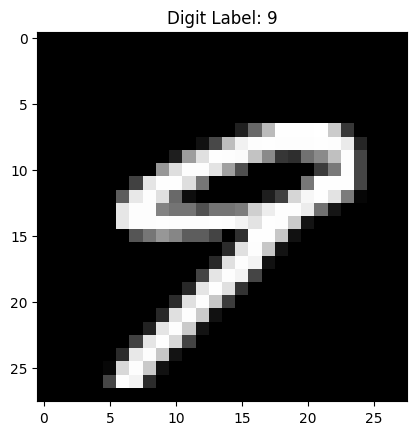

In [8]:
plot_digit(test_data)

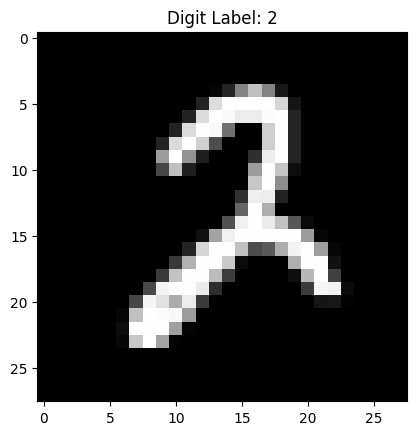

In [9]:
plot_digit(train_data)

In [10]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
class DigitRecognizerNet(nn.Module):
    def __init__(self):
        super(DigitRecognizerNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        output = self.out(x)
        return output, x

In [75]:
class DigitRecognizerNet(nn.Module):
    def __init__(self):
        super(DigitRecognizerNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(9, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = repr_x = self.conv2(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x, repr_x

In [76]:
model = DigitRecognizerNet().to(device)

In [85]:
model.eval()
sample_input = torch.randn((124, 1, 28, 28)).to(device)

In [86]:
out_model = model(sample_input)

In [87]:
out_model[0].shape

torch.Size([124, 10])

In [89]:
out_model[0]

tensor([[-0.2198,  0.1284, -0.1395,  ...,  0.5452, -0.1632, -0.0154],
        [-0.2388,  0.1076, -0.0573,  ...,  0.5240, -0.0981, -0.0469],
        [-0.2214,  0.1045, -0.0936,  ...,  0.5190, -0.1385, -0.0403],
        ...,
        [-0.2275,  0.1372, -0.1503,  ...,  0.5565, -0.1977, -0.0060],
        [-0.1952,  0.1228, -0.1176,  ...,  0.5743, -0.1619, -0.0643],
        [-0.2454,  0.0920, -0.0500,  ...,  0.4910, -0.1592, -0.0675]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [90]:
def plot_conv_digit(conv_tensor: torch.tensor):
    numpy_data = conv_tensor[1][1].to('cpu').squeeze().detach().numpy()
    plt.imshow(numpy_data, cmap='gray')
    plt.colorbar()
    plt.show()

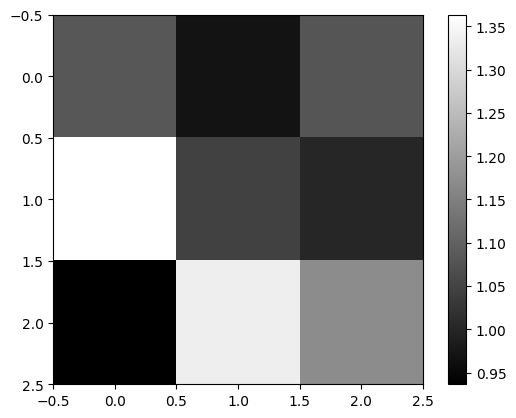

In [91]:
plot_conv_digit(conv_tensor=out_model)

# TODO:
- [ ] treine o modelo e salve essas representações junto com os targets em uma lista
- [ ] use algum modelo de cluster e pegue o k-medoid para pegar o mais fiel a cada digito e plot
- [ ] veja as metricas para uma rede normal
- [ ] veja as metricas para algum modelo comum e compare

In [92]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [93]:
def train_net(n_epochs: int = EPOCHS, loss_func = loss_func, optimizer = optimizer, train_dataset = train_loader, list_repr: List = []):
    model.train()
    total_steps = len(train_dataset)
    for epoch in range(n_epochs):
        for i, (images, labels) in enumerate(train_dataset):
            images, labels = images.to(device), labels.to(device)
            b_images = Variable(images)
            # print(b_images.shape)
            b_labels = Variable(labels)
            output = model(b_images)
            predict = output[0]
            repr = output[1]
            # list_repr.append((repr, labels))
            loss = loss_func(predict, b_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{total_steps}], Loss: {loss.item():.4f}')
                # break
    return list_repr

In [94]:
list_repr = train_net()

Epoch [1/10], Step [100/484], Loss: 0.9801
Epoch [1/10], Step [200/484], Loss: 0.8972
Epoch [1/10], Step [300/484], Loss: 0.7460
Epoch [1/10], Step [400/484], Loss: 0.6831
Epoch [2/10], Step [100/484], Loss: 0.6657
Epoch [2/10], Step [200/484], Loss: 0.7230
Epoch [2/10], Step [300/484], Loss: 0.5639
Epoch [2/10], Step [400/484], Loss: 0.6030
Epoch [3/10], Step [100/484], Loss: 0.8501
Epoch [3/10], Step [200/484], Loss: 0.4928
Epoch [3/10], Step [300/484], Loss: 0.4268
Epoch [3/10], Step [400/484], Loss: 0.3808
Epoch [4/10], Step [100/484], Loss: 0.6109
Epoch [4/10], Step [200/484], Loss: 0.5648
Epoch [4/10], Step [300/484], Loss: 0.5988
Epoch [4/10], Step [400/484], Loss: 0.5671
Epoch [5/10], Step [100/484], Loss: 0.4392
Epoch [5/10], Step [200/484], Loss: 0.4884
Epoch [5/10], Step [300/484], Loss: 0.3604
Epoch [5/10], Step [400/484], Loss: 0.5284
Epoch [6/10], Step [100/484], Loss: 0.4847
Epoch [6/10], Step [200/484], Loss: 0.4444
Epoch [6/10], Step [300/484], Loss: 0.3206
Epoch [6/10

In [22]:
model

DigitRecognizerNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [101]:
def eval_net():
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            predict_output = model(images)[0]
            _, pred_y = torch.max(predict_output, 1)
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total
        print(f'Test acc of the model on the {total} test images: {accuracy}')

# Certifique-se de chamar eval_net depois de treinar o modelo e antes de avaliá-lo no conjunto de teste.
eval_net()

Test acc of the model on the 10000 test images: 0.8691


In [154]:
def get_repr() -> List[Tuple]:
    list_repr_x = []
    list_labels = []
    model.eval()
    with torch.no_grad():
        for images , labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            repr_images = model(images)[1]
            # list_repr.append((repr_images, labels))
            list_repr_x.append(repr_images)
            list_labels.append(labels)
    return list_repr_x, list_labels

In [155]:
list_repr_x, list_labels = get_repr()

In [159]:
len(list_repr_x)

484

In [189]:
new_list_repr_x = [x.cpu().numpy() for i in list_repr_x for x in i.squeeze()]

In [190]:
new_list_repr_x[:3]

[array([[0.7451814, 1.4152701, 1.0714388],
        [2.3601007, 8.300129 , 6.86401  ],
        [1.0476398, 1.940982 , 2.4745617]], dtype=float32),
 array([[1.8979181, 4.773403 , 2.9131825],
        [1.3221076, 5.5599623, 5.714018 ],
        [4.1794286, 4.124875 , 4.028861 ]], dtype=float32),
 array([[0.59270096, 4.4767423 , 3.3146172 ],
        [2.7041616 , 8.121634  , 3.3192053 ],
        [0.25143754, 3.2044773 , 1.5582494 ]], dtype=float32)]

In [191]:
new_list_labels = [x.cpu().item() for i in list_labels for x in i]

In [192]:
new_list_labels[:3]

[4, 3, 9]

In [193]:
dataset_raw = list(zip(new_list_repr_x, new_list_labels))

In [194]:
dataset_raw[:3]

[(array([[0.7451814, 1.4152701, 1.0714388],
         [2.3601007, 8.300129 , 6.86401  ],
         [1.0476398, 1.940982 , 2.4745617]], dtype=float32),
  4),
 (array([[1.8979181, 4.773403 , 2.9131825],
         [1.3221076, 5.5599623, 5.714018 ],
         [4.1794286, 4.124875 , 4.028861 ]], dtype=float32),
  3),
 (array([[0.59270096, 4.4767423 , 3.3146172 ],
         [2.7041616 , 8.121634  , 3.3192053 ],
         [0.25143754, 3.2044773 , 1.5582494 ]], dtype=float32),
  9)]

In [196]:
# para arrumar esses dados eu vou dar um flatten unir com a target e dar um vstack
import numpy as np
dataset = np.vstack([np.hstack((matriz.flatten(), numero)) for matriz, numero in dataset_raw])

In [199]:
dataset

array([[0.74518138, 1.41527009, 1.07143879, ..., 1.94098198, 2.47456169,
        4.        ],
       [1.89791811, 4.77340317, 2.9131825 , ..., 4.12487507, 4.02886105,
        3.        ],
       [0.59270096, 4.47674227, 3.31461716, ..., 3.20447731, 1.55824935,
        9.        ],
       ...,
       [0.43694025, 3.99061918, 3.06488371, ..., 3.84362364, 4.13531923,
        7.        ],
       [0.18982555, 4.30129719, 2.22183204, ..., 4.6230731 , 3.27339077,
        3.        ],
       [0.93292004, 1.72163427, 1.43514264, ..., 2.18693089, 3.74525833,
        4.        ]])

In [211]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report

In [206]:
dataset[:, -1]

array([4., 3., 9., ..., 7., 3., 4.])

In [205]:
X = dataset[:, :-1]
y = dataset[:, -1]

In [210]:
cross_val_score(RandomForestClassifier(max_depth=3, random_state=42), X=X, y=y, cv=3)

array([0.73375, 0.73075, 0.723  ])

In [212]:
y_pred = cross_val_predict(RandomForestClassifier(max_depth=3, random_state=42), X=X, y=y, cv=3)

In [213]:
y_pred

array([4., 3., 9., ..., 7., 3., 4.])

In [214]:
y

array([4., 3., 9., ..., 7., 3., 4.])

In [215]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.79      0.74      5923
         1.0       0.88      0.95      0.91      6742
         2.0       0.88      0.45      0.59      5958
         3.0       0.66      0.53      0.59      6131
         4.0       0.73      0.92      0.82      5842
         5.0       0.85      0.37      0.52      5421
         6.0       0.81      0.82      0.82      5918
         7.0       0.73      0.79      0.76      6265
         8.0       0.56      0.76      0.65      5851
         9.0       0.67      0.86      0.75      5949

    accuracy                           0.73     60000
   macro avg       0.75      0.72      0.71     60000
weighted avg       0.75      0.73      0.72     60000



In [217]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

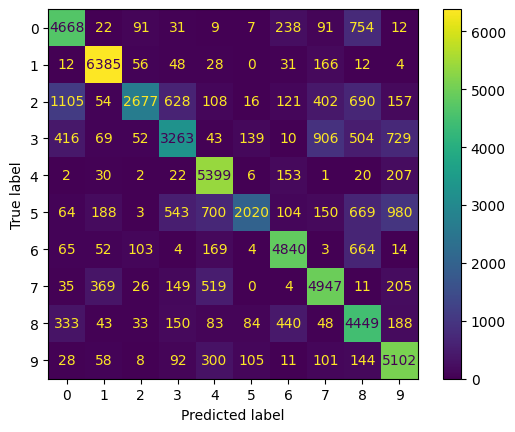

In [219]:
cm = confusion_matrix(y, y_pred, labels=range(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=range(10))
disp.plot()
plt.show()

In [ ]:


3152384 * 6